## 第零部分 初始化

In [2]:
# import packages
import pandas as pd
import numpy as np

# to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [3]:
# read the file
df = pd.read_csv('../res/data_meg.csv')

# print the head
df.head()

,gold,broad_money,petrol_future,M_0
0,331.10,28022.1,28.06,7063.8
1,335.35,28022.1,28.03,7063.8
2,340.90,28022.1,27.99,7063.8
3,321.15,28022.1,27.27,7063.8
4,320.50,28022.1,27.31,7063.8


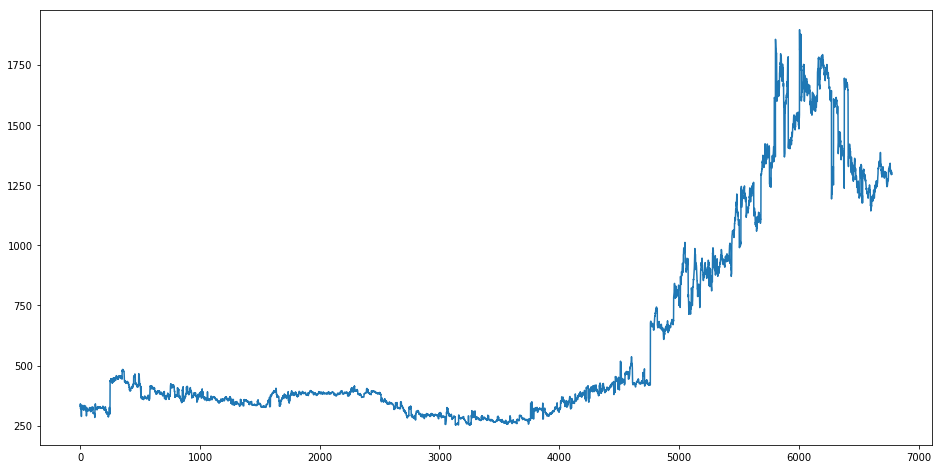

In [3]:
# setting index as date
# df['Ndate'] = pd.to_datetime(df.Ndate,format='%Y-%m-%d')
# df.index = df['Ndate']

# plot
plt.figure(figsize=(16,8))
plt.plot(df['gold'], label='Price History')

In [4]:
# splitting into train and validation
train = df[:5500].copy()
valid = df[5500:].copy()

df.shape, train.shape, valid.shape

((6777, 4), (5500, 4), (1277, 4))

## 第一部分 滑动平均

In [44]:
#make predictions
preds = []
for i in range(0,1277):
    a = train['gold'][len(train)-1277+i:].sum() + sum(preds)
    b = a/1277
    preds.append(b)
preds

[666.9836726703211,
 667.2301360005249,
 667.4761658642685,
 667.6808065579758,
 667.8843545662436,
 668.0863000279243,
 668.293023833741,
 668.497560265874,
 668.7019436333492,
 668.9060955077684,
 669.1102114791919,
 669.3150746048607,
 669.5183362137918,
 669.7212088341628,
 669.9251800235395,
 670.1293109397677,
 670.3314482231976,
 670.5304156846097,
 670.7295389545271,
 670.9684814282581,
 671.2092554935896,
 671.4547208463645,
 671.7027276755316,
 671.95280812007,
 672.2068823629205,
 672.4604507907693,
 672.6736148086164,
 672.8860843581924,
 673.098367901151,
 673.3104652918333,
 673.5226113100726,
 673.765777019791,
 673.9836828749357,
 674.2030123055347,
 674.4215346331036,
 674.6408937048601,
 674.8623039583487,
 675.0840050577679,
 675.3025516553072,
 675.5222090959143,
 675.7349907788399,
 675.9484480934669,
 676.1596058445191,
 676.370889795846,
 676.5828090517551,
 676.7903132091958,
 677.0088255922883,
 677.2300541166361,
 677.447422992217,
 677.6604984996501,
 677.872

In [45]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['gold'])-preds),2)))
rms

677.9595705014203

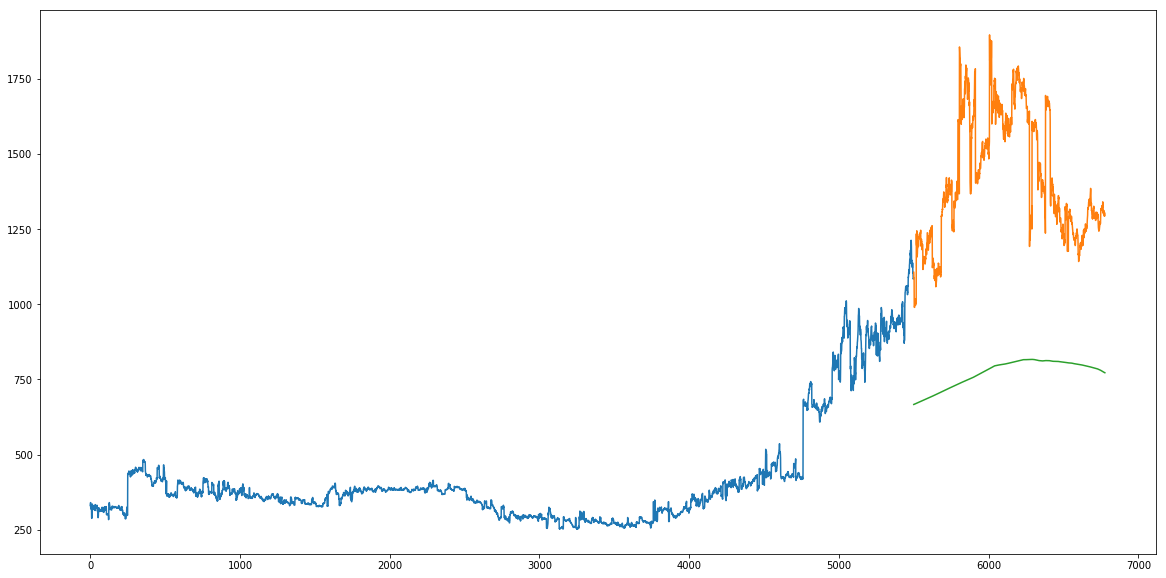

In [46]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['gold'])
plt.plot(valid[['gold', 'Predictions']])

## 第二部分 长短期记忆网络(LSTM)

In [4]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 

Using TensorFlow backend.
C:\Users\hxh85\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hxh85\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hxh85\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hxh85\AppData\Roa

In [5]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['gold'])
for i in range(0,len(data)):
    new_data['gold'][i] = data['gold'][i]

In [6]:
#creating train and test sets
dataset = new_data.values
train = dataset[0:5500,:]
valid = dataset[5500:,:] 

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))

In [7]:
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

d:\visualstudio\shared\python36_64\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

W0925 15:43:34.541574 11688 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\backend\tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0925 15:43:34.603081 11688 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\backend\tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0925 15:43:34.629860 11688 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\backend\tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0925 15:43:35.317318 11688 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0925 15:43:35.777608 11688 deprecation.

Epoch 1/1
 - 486s - loss: 2.8273e-04


In [9]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []

for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [10]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

149.8937494082179

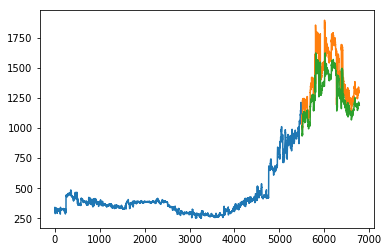

In [11]:
#for plotting
train = new_data[:5500].copy()
valid = new_data[5500:].copy()
valid['Predictions'] = closing_price
plt.plot(train['gold'])
plt.plot(valid[['gold','Predictions']])

In [13]:
type(valid)

pandas.core.frame.DataFrame

In [14]:
valid.to_csv('LSTM_predict.csv')

## 第三部分 神经网络CNN